# Some pratical examples of Partial Rejection Sampling

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Graphs" data-toc-modified-id="Graphs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Graphs</a></span><ul class="toc-item"><li><span><a href="#Random-independent-set" data-toc-modified-id="Random-independent-set-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Random independent set</a></span></li><li><span><a href="#Uniform-sink-free-graph" data-toc-modified-id="Uniform-sink-free-graph-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Uniform sink-free graph</a></span></li><li><span><a href="#Rooted-spanning-forest" data-toc-modified-id="Rooted-spanning-forest-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Rooted spanning forest</a></span></li></ul></li><li><span><a href="#Hard-core-2D" data-toc-modified-id="Hard-core-2D-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Hard-core 2D</a></span></li><li><span><a href="#Dominated-CFTP" data-toc-modified-id="Dominated-CFTP-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dominated CFTP</a></span><ul class="toc-item"><li><span><a href="#Strauss-process" data-toc-modified-id="Strauss-process-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Strauss process</a></span></li></ul></li></ul></div>

In [1]:
using LinearAlgebra
const LA = LinearAlgebra

using Random
using Distributions

getRNG(seed::Integer=-1) = seed >= 0 ? Random.MersenneTwister(seed) : Random.GLOBAL_RNG
getRNG(seed::Union{Random.MersenneTwister, Random._GLOBAL_RNG}) = seed

using Plots

using LightGraphs
const LG = LightGraphs

using GraphPlot, Colors
edgemap(g::LG.AbstractGraph) = Dict{LG.Edge, Int}(e => i for (i, e) in enumerate(LG.edges(g)))

using Distances: pairwise, Euclidean

## Graphs

Construct a connected graph

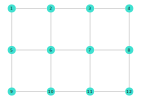

In [2]:
width, height = 10, 8
width, height = 4, 3

g = LG.grid((width, height))

pos = collect(Iterators.product(1:width, 1:height))[:]
locs_x, locs_y = map(x->x[1], pos), map(x->x[2], pos)

gplot(g, 
    locs_x, locs_y,
    nodelabel=LG.vertices(g))

### Random independent set

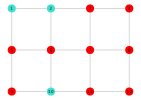

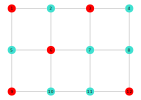

In [3]:
"""
Sample independent set of vertices of a graph
Moka, Kroese
https://arxiv.org/pdf/1901.05624.pdf
"""
function sample_independent_set(graph::LG.SimpleGraph, proba; rng=-1)
    
    !(0.0 <= proba < 1.0) && throw(DomainError(proba, "proba ∉ [0, 1)"))    
    proba == 0.0 && return falses(LG.nv(graph))
    
    adj = LG.adjacency_matrix(graph)
    
    rng = getRNG(rng)
    occup = randsubseq(rng, LG.vertices(graph), proba)
    
    while true
        
        # Check if occup vertices form an independent set
        sub_g = LG.SimpleGraph(adj[occup, occup])
        LG.ne(sub_g) == 0 && return occup
        
        # Identify current independent vertices
        # and construct resampling set of vertices
        ind, res = [], Set()
        for cc in LG.connected_components(sub_g)
            if length(cc) == 1
                append!(ind, occup[cc])
            else
                union!(res, occup[cc])
                for v in cc
                    union!(res, LG.neighbors(graph, occup[v]))
                end
            end
        end
        randsubseq!(rng, occup, collect(res), proba)
        append!(occup, ind)

    end      
                
end

# ν = 0.5; proba = ν / (1 + ν)
proba = 0.8
seed = 0

# initial configuration
occ_init = rand(getRNG(seed), LG.nv(g)) .< proba 

col_nodes = [colorant"turquoise" for _ in 1:LG.nv(g)]
col_nodes[occ_init] .= colorant"red"

p = gplot(g, 
    locs_x, locs_y, 
    nodelabel=LG.vertices(g),
    nodefillc=col_nodes,
#     arrowlengthfrac=0.05
#     edgestrokec=col_edges
)

display(p)


# random independent set
occ = sample_independent_set(g, proba, rng=seed)

col_nodes = [colorant"turquoise" for _ in 1:LG.nv(g)]
col_nodes[occ] .= colorant"red"

p = gplot(g, 
    locs_x, locs_y, 
    nodelabel=LG.vertices(g),
    nodefillc=col_nodes,
#     arrowlengthfrac=0.05
#     edgestrokec=col_edges
)
display(p)

### Uniform sink-free graph

In [4]:
sink_nodes(g::LG.SimpleDiGraph) = [v for v in LG.vertices(g) if LG.outdegree(g, v) == 0]

function random_edge_orientation(graph::LG.SimpleGraph; rng=-1)::LG.SimpleDiGraph
    rng = getRNG(rng)
    return LG.SimpleDiGraph([rand(rng) < 0.5 ? e : reverse(e) for e in LG.edges(graph)])
end

"""
Sample sink free orientation of a graph using Partial Rejection Sampling
H. Guo, M. Jerrum
https://arxiv.org/pdf/1611.01647.pdf
"""
function sample_sink_free_orientation(graph::LG.SimpleGraph; rng=-1)::LG.SimpleDiGraph
    
    rng = getRNG(rng)
    g = random_edge_orientation(graph, rng=rng)

    it = 0
    while true
        sinks = sink_nodes(g)
        isempty(sinks) && break
            
        # Resample i.e. flip edges forming a sink with probability 0.5
        for v in sinks
            for w in LG.inneighbors(g, v)
                if rand(rng) < 0.5
                    LG.rem_edge!(g, w, v)
                    LG.add_edge!(g, v, w)
                end
            end
        end
        it += 1
    end

    return g
end

sample_sink_free_orientation

In [5]:
function color_sinks(graph)

    nodes = []
    edge_idx = []
    
    edge_map = edgemap(graph)
    
    for v in LG.vertices(graph)
        if LG.outdegree(graph, v) == 0
            push!(nodes, v)
            for w in LG.inneighbors(graph, v)
                push!(edge_idx, edge_map[LG.Edge(w, v)])
            end
        end
    end

    col_nodes = [colorant"turquoise" for _ in 1:LG.nv(graph)]
    col_nodes[nodes] .= colorant"red"
    
    col_edges = [colorant"lightgray" for _ in 1:LG.ne(graph)]
    col_edges[edge_idx] .= colorant"red"
    
    return col_nodes, col_edges
    
end

color_sinks (generic function with 1 method)

Consider a random orientation of the edges of the graph

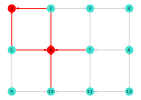

In [6]:
seed = 0
g_oriented = random_edge_orientation(g, rng=seed)

col_nodes, col_edges = color_sinks(g_oriented)

gplot(g_oriented, 
    locs_x, locs_y, 
    nodelabel=LG.vertices(g_oriented),
    nodefillc=col_nodes,
    edgestrokec=col_edges,
    arrowlengthfrac=0.05
)

Apply the uniform sink free sampler, based on partial rejection sampling

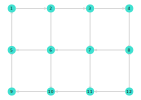

In [7]:
seed = 0
g_sink_free = sample_sink_free_orientation(g, rng=seed)

cols = [LG.outdegree(g_sink_free, v) == 0 ? colorant"red" : colorant"turquoise" 
        for v in LG.vertices(g_sink_free)]
gplot(g_sink_free, 
    locs_x, locs_y,
    nodelabel=LG.vertices(g_sink_free),
    nodefillc=cols,
    arrowlengthfrac=0.05
)

### Rooted spanning forest

In [8]:
function random_neighbor_assignment(graph::LG.SimpleGraph, roots::Array{Int64,1}; rng=-1)::LG.SimpleDiGraph
    
    rng = getRNG(rng)
    
    edges = [(v, rand(rng, LG.neighbors(graph, v))) 
            for v in LG.vertices(graph) if !(v in roots)]

    return LG.SimpleDiGraph(LG.Edge.(edges))
                
end

"""
Sample rooted spanning forest using Partial Rejection Sampling
H. Guo, M. Jerrum
https://arxiv.org/pdf/1611.01647.pdf
"""
function rooted_spanning_forest(graph::LG.SimpleGraph, roots::Array{Int64,1}; rng=-1)::LG.SimpleDiGraph
    
    rng = getRNG(rng)
    g = random_neighbor_assignment(graph, roots, rng=rng)

    it = 0
    while true
        
        vertices_in_cycles = Set(Iterators.flatten(LG.simplecycles(g)))
        isempty(vertices_in_cycles) && break

        # Resample the successor of vertices involved in cycles
        for v in vertices_in_cycles
                        
            # Remove current edge (v, w)
            w = LG.neighbors(g, v)[1]
            LG.rem_edge!(g, v, w)
                        
            # Resample the successor w of v and add edge (v, w)
            w = rand(rng, LG.neighbors(graph, v))
            LG.add_edge!(g, v, w)
        end
                    
        it += 1
    end
                
    return g
end

function rooted_spanning_tree(graph::LG.SimpleGraph, root::Int64; rng=-1)::LG.SimpleDiGraph
    return rooted_spanning_forest(graph, [root], rng=rng)
end

rooted_spanning_tree (generic function with 1 method)

In [9]:
function color_cycles(graph::LG.SimpleDiGraph)

    edge_map = edgemap(graph)
    
    nodes = Set()
    edge_idx = []
    
    for cycle in LG.simplecycles(graph)
        union!(nodes, cycle)
        for (x, y) in zip(cycle, circshift(cycle, -1))
            push!(edge_idx, edge_map[LG.Edge(x, y)])
        end
    end

    col_nodes = [colorant"turquoise" for _ in 1:LG.nv(graph)]
    col_nodes[collect(nodes)] .= colorant"red"
    
    col_edges = [colorant"lightgray" for _ in 1:LG.ne(graph)]
    col_edges[edge_idx] .= colorant"red"
    
    return col_nodes, col_edges
    
end

color_cycles (generic function with 1 method)

Consider a random orientation of the edges of the graph

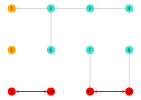

In [10]:
seed = 10

roots = [1, 5]
g_oriented = random_neighbor_assignment(g, roots, rng=seed)

col_nodes, col_edges = color_cycles(g_oriented)
col_nodes[roots] .= colorant"orange"

gplot(g_oriented, 
    locs_x, locs_y, 
    nodelabel=LG.vertices(g_oriented),
    nodefillc=col_nodes,
    edgestrokec=col_edges,
    arrowlengthfrac=0.05
)

Apply the uniform rooted spanning forest sampler, based on partial rejection sampling

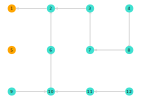

In [11]:
ust = rooted_spanning_forest(g, roots, rng=-1)

in_cycle = collect(Iterators.flatten(LG.simplecycles(ust)))

col_nodes, col_edges = color_cycles(ust)
col_nodes[roots] .= colorant"orange"

gplot(ust, 
    locs_x, locs_y, 
    nodelabel=LG.vertices(ust),
    nodefillc=col_nodes,
    edgestrokec=col_edges,
    arrowlengthfrac=0.05
)

## Hard-core 2D

In [12]:
"""
Sample n points uniformly in B(c, r) (disk of radius r centered at cᵢ)
"""
function sample_in_disk(n, rad, center; rng=-1)
    rng = getRNG(rng)
    r = rad * sqrt.(rand(rng, 1, n))
    theta = 2π .* rand(rng, 1, n)
    return center .+ r .* vcat(cos.(theta), sin.(theta))
end

pairwise_distances(X, Y) = pairwise(Euclidean(1e-8), X, Y, dims=2)
    
function pairwise_distances(X)
    dist = pairwise_distances(X, X)
    dist[LA.diagind(dist)] .= Inf
    return dist
end
    
"""
Sample from Poisson(λ) on ⋃ᵢ B(cᵢ, r) (union of disks of radius r centered at cᵢ)
Use the independence property of the Poisson point process
- Sample from Poisson(λ) on B(c₁, r)
- Sample from Poisson(λ) on B(c₂, r) ∖ B(c₁, r)
- Sample from Poisson(λ) on B(cⱼ, r) ∖ ⋃_i<j B(cᵢ, r)
"""
function poisson_disks(λ, rad, centers; rng=-1)
    rng = getRNG(rng)
    
    𝒫_λ = Poisson(λ)
    n = rand(rng, 𝒫_λ)
    sample = sample_in_disk(n, rad, centers[:, 1], rng=rng)
    
    for (i, c) in enumerate(eachcol(centers[:, 2:end]))
        
        n = rand(rng, 𝒫_λ)
        prop = sample_in_disk(n, rad, c, rng=rng)

        isempty(prop) && continue
        acc = vec(all(pairwise_distances(centers[:, 1:i], prop) .> rad, dims=1))
        
        sample = hcat(sample, prop[:, acc])
    
    end
        
    return sample
end

"""
Sample from spatial hard core model a.k.a Poisson disk sampling 
with intensity λ and radius r on [0, 1]^2, using Partial Rejection Sampling
H. Guo, M. Jerrum
https://arxiv.org/pdf/1801.07342.pdf
"""
function sample_hard_core(λ, rad; rng=-1)

    rng = getRNG(rng)
    
    λᵣ = λ / (π * rad^2)
    n = rand(rng, Poisson(λᵣ))
    
    points = rand(rng, 2, n)
    
    while true
        bad = vec(any(pairwise_distances(points) .< 2rad, dims=2))
        !any(bad) && break

        resampled = poisson_disks(4λ, 2rad, points[:, bad], rng=rng)
        points = hcat(points[:, .!bad], resampled)
    end

    return points     
end

sample_hard_core

In [13]:
seed = 0
l, r = 0.48, 1/200
points = sample_hard_core(l, r, rng=seed);

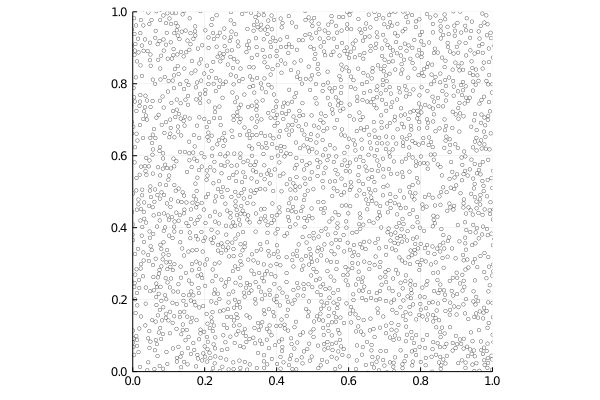

In [14]:
θ = collect(range(0, 2π, length=15))
circ_x, circ_y = r .* cos.(θ), r .* sin.(θ);

p = plot(points[1, 1] .+ circ_x, points[2, 1] .+ circ_y,
         aspect_ratio=:equal,
         label="", color="black", linewidth=0.3)
for (x, y) in eachcol(points[:, 2:end])
    plot!(x .+ circ_x, y .+ circ_y, 
          label="", color="black", linewidth=0.3)
end
xlims!((0, 1))
ylims!((0, 1))
display(p)

## Dominated CFTP

### Strauss process

$\beta > 0$ and $0\leq \gamma\leq 1$

$$
\mathbb{P}[\mathcal{X}=X]
\propto
\beta^{|X|} \gamma^{|\{y ~;~\operatorname{distance}(x, y) \leq r,~x\in X\}|}
$$

Apply dominated CFTP 
- [Kendall \& Moller's orginal formulation of dCFTP](https://www.researchgate.net/publication/2821877_Perfect_Metropolis-Hastings_simulation_of_locally_stable_point_processes)
- Huber, Perfect Simulation
- [Kendall's notes on perfect simulation](https://warwick.ac.uk/fac/sci/statistics/staff/academic-research/kendall/personal/ppt/428.pdf) 

In [19]:
function distance(x, y)
    return sqrt((y[1] - x[1])^2 + (y[2] - x[2])^2)
end

function backward_update_strauss!(D, X, M, n, β; w=1.0, h=1.0, rng=-1)
    
    rng = getRNG(rng)
    b_rate = β * w * h
    
    for _ in -n-1:-1:-2n
        card_D = length(D)
        # forward death ≡ backwards birth
        if rand(rng) < card_D / (b_rate + card_D)
            x = rand(rng, D)
            setdiff!(D, [x])
            pushfirst!(X, x)
            pushfirst!(M, rand(rng))
        else
            x = [w, h] .* rand(rng, 2)
            union!(D, [x])
            pushfirst!(X, x)
            pushfirst!(M, 0.0)
        end
    end
    
    return D, X, M
end

function forward_coupling_strauss(D, X, M, γ, r)
    
    # L: Lower, U: Upper bounding chains
    # L ⊆ X ⊆ U ⊆ D
    
    L, U = Set{Array{Float64, 1}}(), copy(D)
    log_γ = log(γ)
    
    for (x, m) in zip(X, M)
        dist_x_leq_r = y -> distance(x, y) <= r
        if m > 0.0
            log_m = log(m)
            neigh_x_U = count(dist_x_leq_r, U)
            if log_m < neigh_x_U * log_γ
                union!(L, [x])
                union!(U, [x])
            else
                neigh_x_L = count(dist_x_leq_r, L)
                if log_m < neigh_x_L * log_γ
                    union!(U, [x])
                end
            end
        else
            setdiff!(L, [x])
            setdiff!(U, [x])
        end
    end
    
    return L, U
end

function sample_strauss_dcftp(β, γ, r; w=1.0, h=1.0, rng=-1)
    
    @assert β > 0.0
    @assert 0.0 <= γ <= 1.0
    rng = getRNG(rng)
    
    λ = rand(rng, Poisson(β * w * h))
    D = Set([w*rand(rng), h*rand(rng)] for _ in 1:λ)
    X = Array{Float64, 1}[]
    M = Float64[]

    n = 1
    while true
        D, X, M = backward_update_strauss!(D, X, M, n, β, w=w, h=h, rng=rng)
        L, U = forward_coupling_strauss(D, X, M, γ, r)
        if length(L) == length(U)  # coalescence occurs
            return L
        end
        n *= 2
    end
                             
end

sample_strauss_dcftp (generic function with 1 method)

Experimental setup refers to s.9 of [E. Rubak](https://www-ljk.imag.fr/membres/Jean-Francois.Coeurjolly/documents/lecture4.pdf)

In [20]:
β, γ, r = 2, 0.2, 0.7
w, h = 10.0, 10.0
seed = -1
points = sample_strauss_dcftp(β, γ, r, w=w, h=h, rng=seed)
points = hcat(collect(points)...);

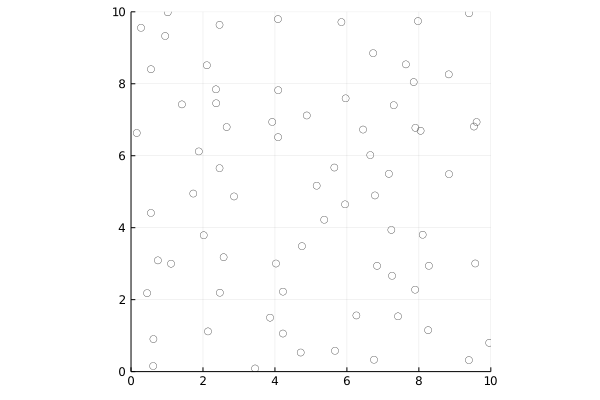

In [21]:
θ = collect(range(0, 2π, length=15))
rad = 0.1
circ_x, circ_y = rad .* cos.(θ), rad .* sin.(θ);

p = plot(points[1, 1] .+ circ_x, points[2, 1] .+ circ_y,
         aspect_ratio=:equal,
         label="", color="black", linewidth=0.3)
for (x, y) in eachcol(points[:, 2:end])
    plot!(x .+ circ_x, y .+ circ_y, 
          label="", color="black", linewidth=0.3)
end
xlims!((0, w))
ylims!((0, h))
display(p)